In [ ]:
!conda install -y pymysql mysql-connector-python MySQLdb

In [ ]:
CREATE USER 'jira'@'%' IDENTIFIED BY 'jira';
GRANT ALL PRIVILEGES ON *.* TO 'jira'@'%';

In [9]:
import os, sys
import pymysql
import pandas as pd
import subprocess
import pathlib
import mysql.connector
from datetime  import datetime 
import pprint
from matplotlib import pyplot as plt


In [3]:
# Execution Example

db = 'issues'
DataPath = './Data'

host = 'localhost'
user = 'jira'
password = 'jira'
port = '3306'

files = pathlib.Path(DataPath)# + '/*.csv', recursive=False)

In [4]:
def run_query(query, host, user, password, database = None ):
    '''
    This function load a csv file to MySQL table according to
    the load_sql statement.
    '''
    try:
        con = pymysql.connect(host=host,
                                user=user,
                                password=password,
                                autocommit=True,
                                local_infile=1, database = database)
        print('Connected to DB: {}'.format(host))
        # Create cursor and execute Load SQL
        cursor = con.cursor()
        cursor.execute(query)
        print('query run succuessfully.')
        con.close()
        return cursor.fetchall()
       
    except Exception as e:
        print('Error: {}'.format(str(e)))
        sys.exit(1)

## Data Exploration

In [21]:
con = mysql.connector.connect(
      host=host,
      user=user,
      passwd=password,
      database=db)

In [54]:
data = pp.read_text()  
data[:500]

'ID,issueid,AUTHOR,CREATED,ID,groupid,FIELDTYPE,FIELD,OLDVALUE,OLDSTRING,NEWVALUE,NEWSTRING\n946521,91221,jeff.kozloff,183330695282512,1508173,946521,jira,priority,NULL,NULL,3,Medium\n946521,91221,jeff.kozloff,183330695282512,1508174,946521,jira,labels,NULL,,NULL,MVP\n946529,91256,jeff.kozloff,183330695283180,1508189,946529,jira,priority,NULL,NULL,3,Medium\n946529,91256,jeff.kozloff,183330695283180,1508190,946529,jira,labels,NULL,,NULL,MVP\n946532,91062,jeff.kozloff,183330695283408,1508195,946532,jira'

In [50]:
#Example 1
request = {'issueid': 163623, 'CREATED': 186421716416622}

In [12]:
#Example 2
request = {'issueid': 133474, 'CREATED': 186925578209167}

In [64]:
changes = pd.read_sql(f"""  
                        select * 
                        from changegroup_changeitem 
                        where issueid  = {request['issueid']} 
                        order by groupid desc;""",con)
                        
                        #and CREATED < {request['CREATED']}

In [65]:
changes

,ID,issueid,AUTHOR,CREATED,ID_2,groupid,FIELDTYPE,FIELD,OLDVALUE,OLDSTRING,NEWVALUE,NEWSTRING
0,2125636.0,163623.0,thuan.pham,1.869213e+14,3174022.0,2125636.0,jira,labels,None,Exapps MBCQA NOV-06,None,BE_Issue Exapps MBCQA NOV-06
1,2045027.0,163623.0,tala.alnaber,1.865219e+14,3041156.0,2045027.0,jira,status,11030,Verified,6,Closed
2,2041736.0,163623.0,hai.hoang,1.865090e+14,3035578.0,2041736.0,jira,assignee,hai.hoang,Hai Hoang,tala.alnaber,Tala Alnaber
3,2041735.0,163623.0,hai.hoang,1.865090e+14,3035577.0,2041735.0,jira,status,5,Resolved,11030,Verified
4,2036105.0,163623.0,sang.le,1.864789e+14,3026628.0,2036105.0,jira,status,11724,In Review,5,Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...
63,2009637.0,163623.0,tram.nguyen,1.863758e+14,2984166.0,2009637.0,jira,assignee,huybao.nguyen,Bao Nguyen Vo Huy,tram.nguyen,Tram Nguyen Thi Phuong
64,2009528.0,163623.0,momen.barakat,1.863715e+14,2984010.0,2009528.0,jira,assignee,salim.haddad,Salim Haddad,huybao.nguyen,Bao Nguyen Vo Huy
65,2009527.0,163623.0,momen.barakat,1.863715e+14,2984009.0,2009527.0,jira,priority,3,Medium,1,Highest
66,2009526.0,163623.0,momen.barakat,1.863715e+14,2984008.0,2009526.0,jira,description,None,Steps:\n # Navigate to any page\n # click on a...,None,"Steps:\n # Navigate to a page that has apps, f..."


In [54]:
change = pd.read_sql(f"""select *
                        from changegroup_changeitem 
                        where issueid  = {request['issueid']} and CREATED < {request['CREATED']}
                        order by CREATED desc
                        limit 1""",con)

In [55]:
change

,ID,issueid,AUTHOR,CREATED,ID_2,groupid,FIELDTYPE,FIELD,OLDVALUE,OLDSTRING,NEWVALUE,NEWSTRING
0,2021929.0,163623.0,huybao.nguyen,1.864145e+14,3003700.0,2021929.0,jira,RemoteIssueLink,None,None,61022,"This issue links to ""Page (Pyco Confluence)"""


## A diagram of events of a single issue across time 

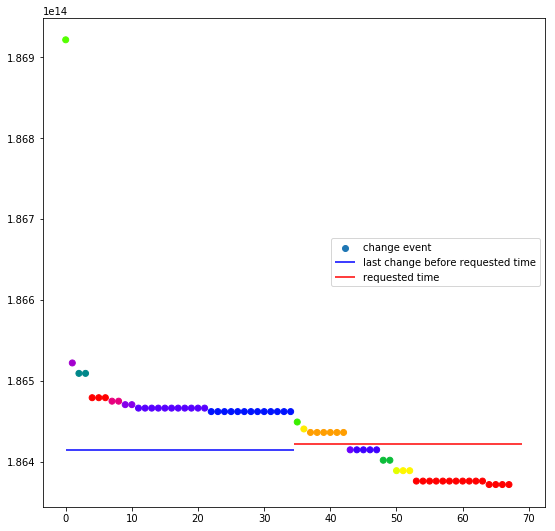

In [66]:
%matplotlib inline
#%matplotlib notebook
w = len(changes)
plt.figure(figsize=[9,9])
plt.scatter(list(range(len(changes))),changes.CREATED,c=changes.CREATED, cmap='prism', label='change event')
plt.hlines(change.CREATED, xmin=0, xmax=(w+1)/2,color='blue', label= 'last change before requested time')
plt.hlines(request['CREATED'], xmin=(w+1)/2, xmax=w+1,color='red', label= 'requested time')
plt.legend(loc=7)

## A diagram of specific  fields changes across time

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

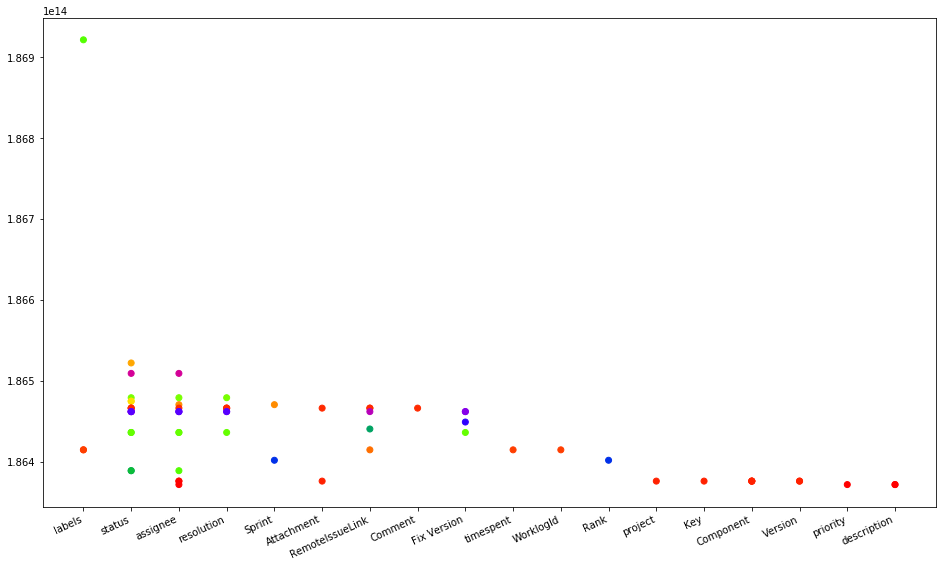

In [67]:
%matplotlib inline
plt.figure(figsize=[16,9])
plt.scatter(changes.FIELD,changes.CREATED,c=changes.groupid, cmap='prism')
plt.xticks(rotation=25, ha='right')

LEt's get some idea about how reasonable is the timestamp

In [56]:
f = changes.CREATED[0]

todate = lambda x: datetime.fromtimestamp(x/100000).strftime("%Y/%m/%d %H:%M:%S.%f")
d = todate(f)
d

'2029/01/26 19:59:44.200500'

In [ ]:
print(changes.CREATED.to_string(float_format=todate), changes.groupid.to_string())

In [68]:
q = f"select * from jiraissue where ID = {request['issueid']}"
q = """
select i.*, t.pname as issue_type 
from jiraissue i
join issuetype t on i.issuetype = t.ID 
where i.ID = 163623
"""
print(q)
issue = pd.read_sql(q,con) # 
print(f'this issue is a {issue.issue_type[0]}')



select i.*, t.pname as issue_type 
from jiraissue i
join issuetype t on i.issuetype = t.ID 
where i.ID = 163623

this issue is a Bug


## Summary of what fields to take

In [ ]:
# Created (the date when the bug open)
# Closed (the date when the bug solved)
# Updated Date (the date when field value changed)
# Summary
# Description
# Closed date (if applicable) 
# Status
# Priority
# Assignee
# Reporter

In [514]:
req_fields = {'status':1, 'Priority':1,'Assignee':1,'Reporter':1,'issuetype':1,'Summary':1,'Description':1}

## A draft for the main API function

In [645]:
now = pd.DataFrame(data=None, columns=changes.columns)
req_fields = {'status':1, 'priority':1,'assignee':1,'reporter':1,'issuetype':1,'summary':1,'description':1}

for index, row in changes.iterrows():


    #print(row.FIELD)            #is empty
    if not req_fields:

        break
    if row.FIELD.lower() in req_fields:

        now = now.append(row)
        del req_fields[row.FIELD]
        
result = {'created': issue.CREATED[0], 'closed':issueclosed.CREATED[0],'updated':now.CREATED.max(),'summary':None,
          'description':None, 'closed_date':issue.RESOLUTIONDATE[0], 'status':None, 
          'priority':None,'assignee':None,'reporter':None,'issuetype':issue.issue_type[0]}

for index, row in now.iterrows():
    result[row.FIELD] = row.NEWSTRING if not None else  row.NEWVALUE
print(now)  

           ID   issueid         AUTHOR       CREATED       ID_2    groupid  \
0   2029581.0  163623.0       tao.tran  1.864617e+14  3016056.0  2029581.0   
3   2029172.0  163623.0   hung.phamtan  1.864617e+14  3015333.0  2029172.0   
37  2009527.0  163623.0  momen.barakat  1.863715e+14  2984009.0  2009527.0   
38  2009526.0  163623.0  momen.barakat  1.863715e+14  2984008.0  2009526.0   

   FIELDTYPE        FIELD      OLDVALUE  \
0       jira       status             3   
3       jira     assignee  hung.phamtan   
37      jira     priority             3   
38      jira  description          None   

                                            OLDSTRING  NEWVALUE  \
0                                         In Progress     11724   
3                                       Hung Pham Tan  tao.tran   
37                                             Medium         1   
38  Steps:\n # Navigate to any page\n # click on a...      None   

                                            NEWSTRING  
0